In [30]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import arviz as az

from scipy import stats
from scipy.special import expit

from theano import tensor as tt

from causalgraphicalmodels import CausalGraphicalModel
import daft

import warnings

print('Running on pymc3 version {}'.format(pm.__version__))

warnings.filterwarnings('ignore')
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")

Running on pymc3 version 3.11.2


In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_rows = 200

In [32]:
def standardize(array, reference=None):
    if reference is None:
        reference = array
    return (array - reference.mean()) / reference.std() 

## Ex. 1

The data in data(bangladesh) are 1934 women from the 1989 Bangladesh Fertility Survey. For each woman, we know which district she lived in, her number of living.children, her age.centered, whether she lived in an urban center, and finally whether or not she used contraception (use.contraception).
In this first problem, I only want you to investigate the proportion of women using contraception in each district. Use partial pooling (varying effects). Then compare the varying effect estimates to the raw empirical proportion in each district. Explain the differences between the estimates and the data.

In [33]:
df = pd.read_csv('data/bangladesh.csv', sep=';')
print(df.shape)
df.head()

(1934, 6)


,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


Model definition 

\begin{split}\begin{aligned}
S_i  &\sim Bernoulli(p_i) \\
logit(p_i) &= \alpha_D[_i] \\
\alpha_j &\sim Normal(\bar{\alpha}, \sigma) \\
\bar{\alpha} &\sim Normal(0, 1.5) \\
\sigma &\sim Exponential(1) \\


\end{aligned}\end{split}




In [38]:
df['district_id'] = pd.factorize(df.district)[0]
district_idx = pd.factorize(df.district)[1]

In [45]:
df[df.district_id == 10]

,woman,district,use.contraception,living.children,age.centered,urban,district_id
364,365,11,0,1,-9.5599,0,10
365,366,11,0,1,-8.5599,0,10
366,367,11,0,2,-5.5599,0,10
367,368,11,0,2,18.4400,0,10
368,369,11,0,1,-8.5599,0,10
369,370,11,0,1,-9.5599,0,10
370,371,11,0,1,-12.5590,0,10
371,372,11,0,1,3.4400,0,10
372,373,11,0,1,-8.5599,0,10
373,374,11,0,4,19.4400,0,10


In [46]:

with pm.Model() as m_7_1:
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    sigma = pm.Exponential("sigma", 1)

    a = pm.Normal('a', a_bar, sigma, shape=len(district_idx))
    p = pm.math.invlogit(a[df['district_id']])

    S = pm.Bernoulli("S", p=p, observed=df['use.contraception'])
    trace_7_1 = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [47]:
az.summary(trace_7_1, round_to=2)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-0.53,0.09,-0.70,-0.38,0.00,0.00,3309.76,3174.32,1.0
a[0],-0.99,0.20,-1.35,-0.61,0.00,0.00,5331.47,2420.46,1.0
a[1],-0.59,0.34,-1.23,0.04,0.00,0.00,6620.69,2643.14,1.0
a[2],-0.24,0.49,-1.19,0.68,0.01,0.01,6165.61,2632.44,1.0
a[3],-0.19,0.30,-0.79,0.35,0.00,0.00,6596.81,2438.55,1.0
a[4],-0.57,0.27,-1.10,-0.09,0.00,0.00,6313.53,3136.74,1.0
a[5],-0.81,0.24,-1.31,-0.39,0.00,0.00,7432.37,2872.26,1.0
a[6],-0.75,0.37,-1.43,-0.07,0.00,0.00,6376.41,2782.68,1.0
a[7],-0.52,0.29,-1.12,-0.02,0.00,0.00,6136.06,2678.26,1.0
a[8],-0.70,0.34,-1.37,-0.10,0.00,0.00,6286.76,2967.61,1.0


In [48]:
#extract hdis for each datapoint
hdi_low = []
hdi_high = []
for x in range(len(district_idx)):
    y = az.hdi(expit(trace_7_1['a'][:,x]))[0]
    z = az.hdi(expit(trace_7_1['a'][:,x]))[1]
    hdi_low.append(y)
    hdi_high.append(z)


In [50]:
df_grouped = df.groupby('district_id').agg({'use.contraception':'mean'}).reset_index()

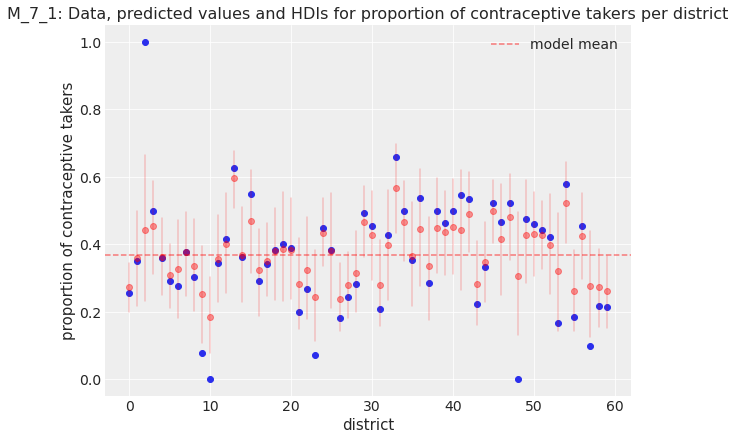

In [51]:
#visualize data and HDIs

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df_grouped['district_id'], df_grouped['use.contraception']) #real data

for x in range(len(district_idx)):
    ax.scatter(x, expit(trace_7_1['a'][:,x]).mean(), color='r', alpha=0.4) # mean predictions


for x, lower, upper in zip(df_grouped['district_id'], hdi_low, hdi_high):
    ax.plot((x, x), (lower, upper), color='r', alpha=0.2)

ax.axhline(y=expit(trace_7_1['a_bar']).mean(), linestyle='dashed', color='r', alpha=0.5, label='model mean')
ax.set(title='M_7_1: Data, predicted values and HDIs for proportion of contraceptive takers per district',xlabel='district',ylabel='proportion of contraceptive takers')

ax.legend()


## Ex. 2

First, draw a DAG that includes all five variables: \
(1) Uses contraception C \
(2) Age A \
(3) Children K \
(4) Urban U \
(5) District D

You don’t have to be an expert on fertility. But do think about which variables can influence which other variables.

Second, design an estimation strategy to identify both the total and direct causal effects of living in an urban center on contraceptive use. Those are your estimands. Consider causal relationships among the variables. Then use your DAG to justify an adjustment set that will yield the estimate of the causal effect of urban living on contraceptive use.

<Axes:>

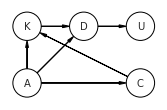

In [52]:
dag = CausalGraphicalModel(
    nodes=["C", "A", "K", "U", "D"],
    edges=[
        ("D", "U"),
        ("A", "K"),
        ("A", "D"),
        ("K", "D"),

        ("A", "C"),
        ("C", "K")
    ],
)
pgm = daft.PGM()
coordinates = {
    "C": (4, 1),
    "A": (2, 1),
    "K": (2, 2),
    "U": (4, 2),
    "D": (3, 2),

}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

Adjustment set
- D (to block the backdoor path)
- K (to block the collider D)
- A (to block collider K)

# Ex. 3

Now build one or more statistical models to estimate the total and the direct causal effects of urban living on contraceptive use. Again include district as a simple varying effect (as in problem 1) so that each district has its own average contraceptive use. 

You may also want to stratify the effect of urban living by district. 

If you do, think carefully about how to do this statistically.

In [53]:
df.head()

,woman,district,use.contraception,living.children,age.centered,urban,district_id
0,1,1,0,4,18.4400,1,0
1,2,1,0,1,-5.5599,1,0
2,3,1,0,3,1.4400,1,0
3,4,1,0,4,8.4400,1,0
4,5,1,0,1,-13.5590,1,0


In [54]:
df.urban.unique()

array([1, 0])

## a) Estimate causal effect

MODEL 7_2:
In the first model, we will add to the varying effects model:
- effect of urban/non-urban area
- effect of number of children modelled as continuous variable
- effect of age modelled as continuous variable

In [55]:

with pm.Model() as m_7_2:
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    sigma = pm.Exponential("sigma", 1)

    b_u = pm.Normal('b_u', 0, 0.5, shape=2)
    b_k = pm.Normal('b_k', 0, 0.5)
    b_a = pm.Normal('b_a', 0, 0.5)

    a = pm.Normal('a', a_bar, sigma, shape=len(district_idx))
    p = pm.math.invlogit(a[df['district_id']] + b_u[df['urban']] + b_k*df['living.children'] + b_a*df['age.centered'])

    S = pm.Bernoulli("S", p=p, observed=df['use.contraception'])
    trace_7_2 = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_a, b_k, b_u, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


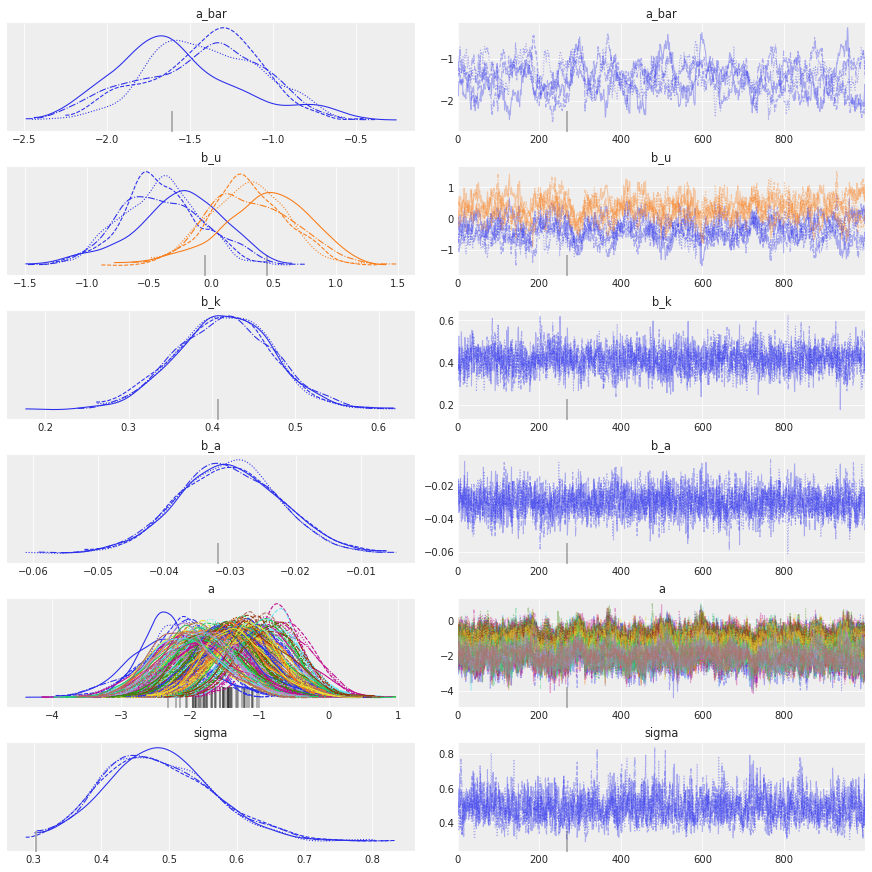

In [56]:
pm.plot_trace(trace_7_2);

We see that especially the a_bar and b_u parameter estimation model is not converging well, therefore we will try to reparametrize it.

Model 7_3:

In [62]:
with pm.Model() as m_7_3:
    a_bar = pm.Normal("a_bar", 0.0, 1.5)
    sigma = pm.Exponential("sigma", 1)

    b_u = pm.Normal('b_u', 0, 0.5, shape=2)
    b_k = pm.Normal('b_k', 0, 0.5)
    b_a = pm.Normal('b_a', 0, 0.5)

    #reparametrization
    z = pm.Normal('z', 0, 1, shape=len(district_idx))

    a = pm.Deterministic('a', a_bar + z[df['district_id']]*sigma)

    p = pm.math.invlogit((a_bar + z[df['district_id']]*sigma) + b_u[df['urban']] + b_k*df['living.children'] + b_a*df['age.centered'])

    S = pm.Bernoulli("S", p=p, observed=df['use.contraception'])
    trace_7_3 = pm.sample(draws=2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, b_a, b_k, b_u, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 48 seconds.


In [63]:
pm.plot_trace(trace_7_3);

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


In [ ]:
az.summary(trace_7_3, round_to=2)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_bar,-1.39,0.38,-2.10,-0.68,0.00,0.00,7123.37,5651.94,1.0
b_u[0],-0.43,0.35,-1.11,0.21,0.00,0.00,7614.99,5993.12,1.0
b_u[1],0.27,0.35,-0.38,0.93,0.00,0.00,7620.95,5928.76,1.0
b_k,0.41,0.06,0.31,0.52,0.00,0.00,10602.63,6292.23,1.0
b_a,-0.03,0.01,-0.04,-0.02,0.00,0.00,10686.96,6474.87,1.0
z[0],-1.51,0.48,-2.39,-0.61,0.01,0.00,9315.28,5658.04,1.0
z[1],-0.03,0.70,-1.32,1.29,0.01,0.01,18348.99,5551.15,1.0
z[2],0.42,0.93,-1.35,2.10,0.01,0.01,20232.34,6053.09,1.0
z[3],0.43,0.63,-0.74,1.62,0.00,0.01,16721.94,5713.74,1.0
z[4],-0.03,0.60,-1.09,1.18,0.00,0.01,15435.40,5419.29,1.0


In [59]:
az.compare({"m7_2": trace_7_2, "m7_3": trace_7_3},'waic')

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m7_3,0,-1216.561572,36.228521,0.000000,1.0,14.792059,0.000000,False,log
m7_2,1,-1216.779523,36.399696,0.217951,0.0,14.814436,0.108016,False,log
